# Multi-class Image Classification

> Add blockquote



We've just been through a bunch of the following steps with a binary classification problem (pizza vs. steak), now we're going to step things up a notch with 10 classes of food (multi-class classification).

1. Becode one with the data
2. Preprocess the dta (get it ready for a model)
3. Create a model (start with a baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust different typerparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat until satisfied


### 0. General Functions

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Let's visualize our images
def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

# Plot the validation and training curves separetly
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  # How many epochs did we run for?
  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

# Create a function to import the image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it
  to (img_shape, img_shape, colour_channel).
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image

  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all vaues between 0 and 1)
  img = img/255.

  return img

# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
      pred_class = class_names[pred.argmax()]
  else:
      pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

### 1. Import and become one with the data

Dataset link: https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Miror   link: https://drive.google.com/uc?export=download&id=1IC6tifXrO4tVEpethHFimte1XRV8o35s

In [ ]:
# Downlaod via original link:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

In [6]:
# Donwload via mirorred link
!pip install gdown

import gdown

# Google Drive file ID
file_id = "1IC6tifXrO4tVEpethHFimte1XRV8o35s"
url = f"https://drive.google.com/uc?id={file_id}"

# Download and save as zip
output = "10_food_classes_all_data.zip"
gdown.download(url, output, quiet=False)

print("Download completed!")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Downloading...
From (original): https://drive.google.com/uc?id=1IC6tifXrO4tVEpethHFimte1XRV8o35s
From (redirected): https://drive.google.com/uc?id=1IC6tifXrO4tVEpethHFimte1XRV8o35s&confirm=t&uuid=4368f7e0-72fe-4cba-81c2-daa4f576bdfb
To: /home/jovyan/10_food_classes_all_data.zip
100% 519M/519M [01:11<00:00, 7.23MB/s] 

Download completed!


In [7]:
import zipfile

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [8]:
import os

# Walk through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_all_data'
There are 10 directories and 0 images in '10_food_classes_all_data/test'
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'
There are 10 directori

In [9]:
!ls 10_food_classes_all_data

test  train


In [10]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [11]:
# Let's get the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 512, 3)


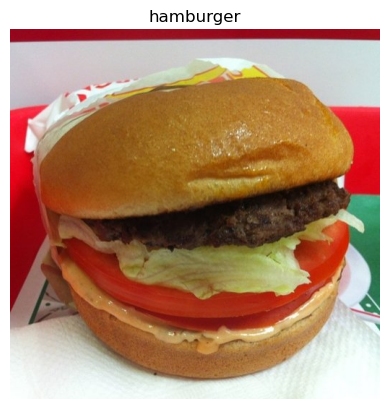

In [13]:
# Visualize, visualize, visualize
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

### 2. Preprocess the data (prepare it for a model)

In [15]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a model (start with a baseline)

In [16]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [20]:
# Create our model (very similar to previous model but actually the same as CNN explorer)
model_8 = Sequential([
    Input(shape=(224, 224, 3)),        # input layer (specify input shape)
    Conv2D(10, 3, activation=relu),
    Conv2D(10, 3, activation=relu),
    MaxPool2D(),
    Conv2D(10, 3, activation=relu),
    Conv2D(10, 3, activation=relu),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation=softmax)
])

In [22]:
# Compile the model
model_8.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

### 4. Fit a model

In [23]:
# Fit the model
history_8 = model_8.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1757755132.504610    3796 service.cc:148] XLA service 0x730ae00044a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757755132.506814    3796 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-09-13 09:18:52.702214: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757755133.097427    3796 cuda_dnn.cc:529] Loaded cuDNN version 90501


  1/235 ━━━━━━━━━━━━━━━━━━━━ 32:56 8s/step - accuracy: 0.0312 - loss: 2.3373

I0000 00:00:1757755139.184531    3796 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 44s 151ms/step - accuracy: 0.1735 - loss: 2.2090 - val_accuracy: 0.2336 - val_loss: 2.0696
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - accuracy: 0.3256 - loss: 1.9194 - val_accuracy: 0.3588 - val_loss: 1.8268
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - accuracy: 0.5113 - loss: 1.4771 - val_accuracy: 0.3420 - val_loss: 1.9233
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - accuracy: 0.7320 - loss: 0.8573 - val_accuracy: 0.3056 - val_loss: 2.4601
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - accuracy: 0.9113 - loss: 0.3301 - val_accuracy: 0.2752 - val_loss: 3.6628


### 5. Evaluate the model

In [25]:
# Evaluate on the test data
model_8.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.2688 - loss: 3.7656


[3.6627726554870605, 0.2752000093460083]

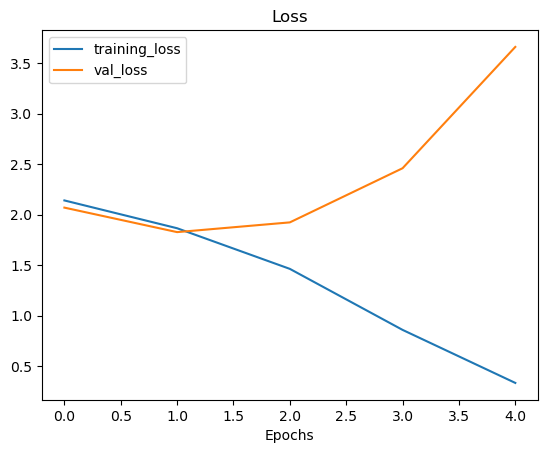

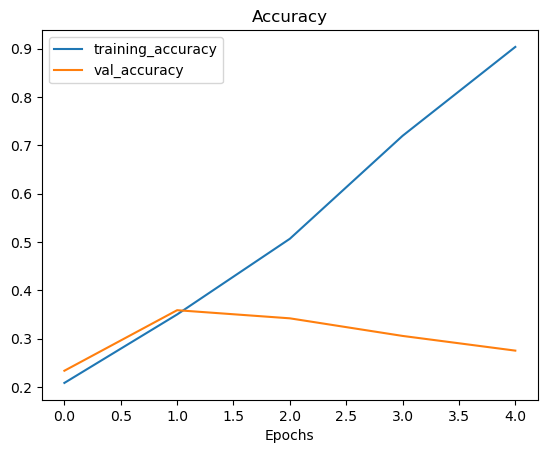

In [27]:
# Check out the model's loss curves on the 10 classes
plot_loss_curves(history_8)

What do these loss curves tell us?

Well... it seems our model is **overfitting** the training set quite badly... in other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test dataset.

### .6 Adjust the model hyperparameters (to beat the baseline/reduce overfitting)

Due to its performance on the training data, it's clear our model is learning something...

However, it's not generalizing well to unseen data (overfitting).

So, let's try and fix overfitting by...

* **Get more data** - having more data gives a model more opportunity to learn diverse patterns...
* **Simpliy the model** - if our current model is overfitting the data, it maybe too complicated of amodel, one way to simplify a model is:
  1. to reduce of layers
  2. to reduce of hidden units in layers
* **Use data augmentation** - data augmentation manipulates the training data in such a way to add more diversity to it (without altering the original data)
* **Use transfer learning** - transfer learning leverage the patterns another model has learned on similar data to your own and allows you to use those patterns on your own dataset.

In [24]:
# Summary
model_8.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │       280,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851,762 (3.25 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 567,842 (2.17 MB)

In [28]:
# How about we try and simplify the model first?

# Let's try to remove 2 convolutional layers
model_9 =  Sequential([
    Input(shape=(224, 224, 3)),        # input layer (specify input shape)
    Conv2D(10, 3, activation=relu),
    MaxPool2D(),
    Conv2D(10, 3, activation=relu),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation=softmax)
])


In [29]:
model_9.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

In [31]:
# Fit the model with 2x conv layers
history_9 = model_9.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.1988 - loss: 2.1855 - val_accuracy: 0.3028 - val_loss: 1.9729
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - accuracy: 0.3821 - loss: 1.8071 - val_accuracy: 0.3060 - val_loss: 1.9721
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - accuracy: 0.5732 - loss: 1.3494 - val_accuracy: 0.2796 - val_loss: 2.0969
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - accuracy: 0.7414 - loss: 0.8625 - val_accuracy: 0.2776 - val_loss: 2.4842
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 132ms/step - accuracy: 0.8848 - loss: 0.4386 - val_accuracy: 0.2840 - val_loss: 2.9676


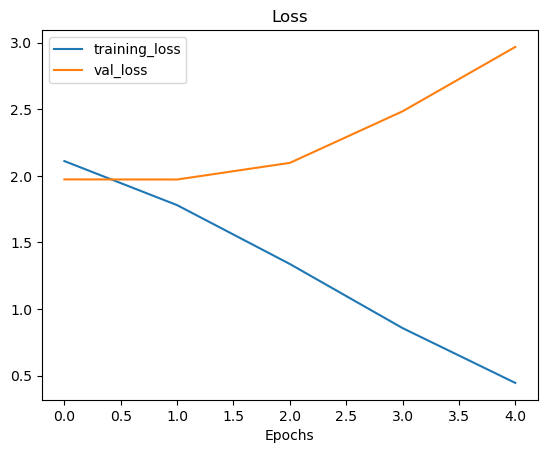

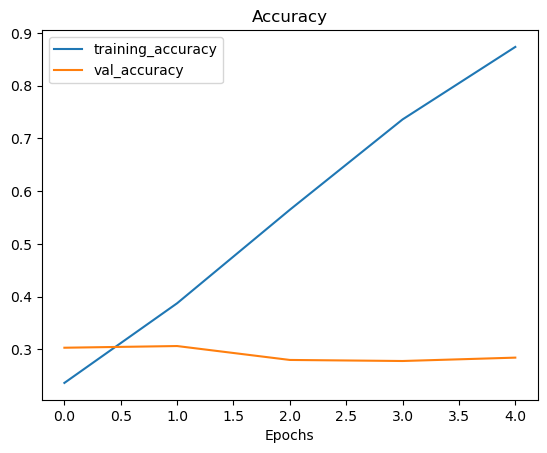

In [32]:
# Check out the model_9 loss curves
plot_loss_curves(history_9)

Looks like our "simplifying the model" experiment didn't work...
the accuracy went down and overfitting continued...

How about we try data augmentation??

### Trying to reduce overfitting with data augmentation

Let's try and improve our model's results by using augmented training data...

Ideally, we want to:
* Reduce overfitting (get the train and validation loss curves closer)
* Improve validation accuracy

In [33]:
# Create an augmented data generator instance
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,      # how much do you want to rotate an image?
                                             shear_range=0.2,         # how much do you want to shear an image?
                                             zoom_range=0.0,          # zoom in randomly on an image
                                             width_shift_range=0.2,   # move your image around on the x-axis
                                             height_shift_range=0.2,  # move your image around on the y-axis
                                             horizontal_flip=True)    # do you want to flip an image?

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")

Found 7500 images belonging to 10 classes.


In [34]:
# Let's create another model but this time we'll fit it on the augmented training data of 10 classes
model_10 = tf.keras.models.clone_model(model_8)

# Compile the cloned model (using the same setup as previous models)
model_10.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

In [35]:
# Fit the model
history_10 = model_10.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 89s 366ms/step - accuracy: 0.1497 - loss: 2.2464 - val_accuracy: 0.2712 - val_loss: 2.0390
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 87s 370ms/step - accuracy: 0.2498 - loss: 2.0882 - val_accuracy: 0.3064 - val_loss: 1.9300
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 349ms/step - accuracy: 0.2889 - loss: 2.0037 - val_accuracy: 0.3564 - val_loss: 1.8287
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 88s 374ms/step - accuracy: 0.3150 - loss: 1.9439 - val_accuracy: 0.3840 - val_loss: 1.8005
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 77s 326ms/step - accuracy: 0.3532 - loss: 1.8836 - val_accuracy: 0.4068 - val_loss: 1.7375


In [37]:
model_10.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │       280,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851,762 (3.25 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 567,842 (2.17 MB)

In [ ]:
# Check out the model_10 loss curves
plot_loss_curves(history_10)

Woah! That looks much better, the loss curves are much closer to each other than the baseline model and they look like they're heading in the right direction (certainly not the wrong direction) so if we were to train for longer, we might see further improvements.

### 7. Repeat until satisfied

We could keep going here... continually training to bring our loss curves closer together and trying to improve the validation/test accuracy.

How?

By running lots of experiments, namely:
- restructuring our model's architecture (increasing layers/hidden units)
- adjust the learning rate
- try different methods of data augmentation (adjust the hyperparametes in our ImageDataGenerator instance)
- training for longer (e.g. 10 epochs instead of 5 epochs)
- try **transfer learning**

### Making a prediction with our trained model

In [38]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [40]:
# Download some custom images
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

--2025-09-13 11:03:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
185.199.108.133, 185.199.109.133, 185.199.110.133, ...tent.com)... 
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M   412KB/s    in 6.2s    

2025-09-13 11:03:21 (453 KB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]

--2025-09-13 11:03:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
185.199.108.133, 185.199.109.133, 185.199.110.133, ...tent.com)... 
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


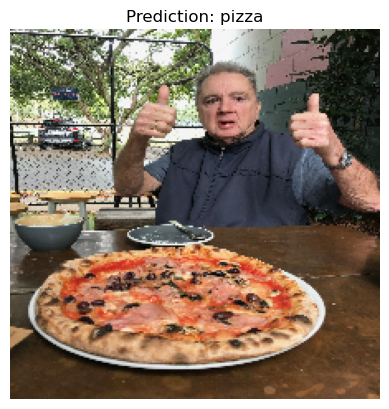

In [50]:
# Make a prediction using model_10
pred_and_plot(model=model_10,
             filename="03-pizza-dad.jpeg",
             class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


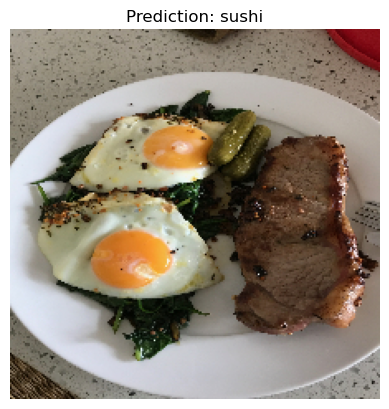

In [51]:
pred_and_plot(model=model_10,
             filename="03-steak.jpeg",
             class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


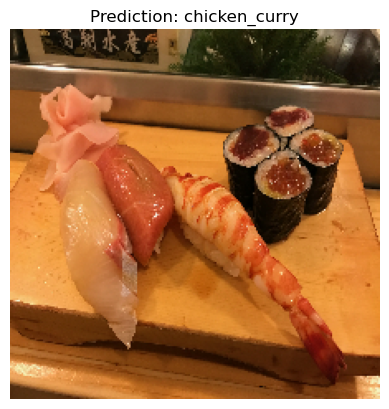

In [52]:
pred_and_plot(model=model_10,
             filename="03-sushi.jpeg",
             class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


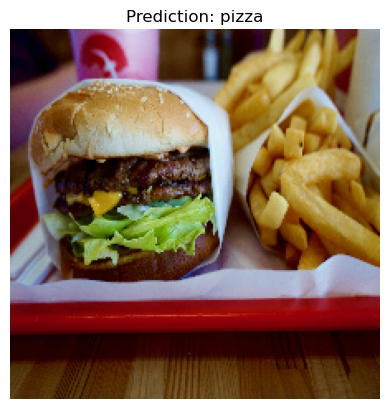

In [53]:
pred_and_plot(model=model_10,
             filename="03-hamburger.jpeg",
             class_names=class_names)